# Building an autoencoder based on Inception Nucleus Encoder

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, concatenate, Conv1DTranspose
from tensorflow.keras.models import Model

def InceptionNucleus(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def InceptionNucleusTranspose(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1DTranspose(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_autoencoder(input_shape=(178, 1)):
    # Encoder
    inputs = Input(shape=input_shape)

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12])

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x)  # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2))(x)  # Compressed representation (encoder output)

    # Decoder: reverse the encoder
    x = UpSampling2D((2, 2))(encoded)  # Reverse the max-pooling
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Reshape back to 1D format for InceptionNucleusTranspose
    x = Reshape((178, 96 * 64))(x)  # Flatten the feature maps
    x = Conv1D(96, kernel_size=1, activation='relu')(x)  # Reduce feature maps from 96 * 64 to 96

    # InceptionNucleusTranspose: reverse the multi-scale convolutions
    x = InceptionNucleusTranspose(x, filters=[4, 8, 12])

    # Final reconstruction layer to original input dimensions
    outputs = Conv1D(1, kernel_size=1, padding='same', activation='sigmoid')(x)

    # Autoencoder Model
    autoencoder = Model(inputs=inputs, outputs=outputs)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Create the autoencoder
autoencoder = create_eeg_autoencoder(input_shape=(178, 1))
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 178, 1)]             0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 178, 32)              160       ['input_2[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 178, 32)              288       ['input_2[0][0]']             
                                                                                                  
 conv1d_5 (Conv1D)           (None, 178, 32)              416       ['input_2[0][0]']             
                                                                                              

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load the data
train_data = pd.read_csv('hard_test_cases/train.csv', index_col=0)
test_data = pd.read_csv('hard_test_cases/test.csv', index_col=0)

X_train = train_data.iloc[:, :-1].values  # X1-X178
y_train = train_data.iloc[:, -1].values   # y

X_test = test_data.iloc[:, :-1].values    # X1-X178
y_test = test_data.iloc[:, -1].values     # y


In [21]:
# 2. Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data
X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

# 3. Define and compile the autoencoder
autoencoder = create_eeg_autoencoder(input_shape=(178, 1))
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')  # Include loss function here
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 178, 1)]             0         []                            
                                                                                                  
 conv1d_33 (Conv1D)          (None, 178, 32)              160       ['input_8[0][0]']             
                                                                                                  
 conv1d_34 (Conv1D)          (None, 178, 32)              288       ['input_8[0][0]']             
                                                                                                  
 conv1d_35 (Conv1D)          (None, 178, 32)              416       ['input_8[0][0]']             
                                                                                            

In [22]:
# 4. Train the autoencoder
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  # Training the autoencoder to reconstruct the input
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/3
260/260 [==============================] - 2996s 12s/step - loss: 0.0014 - val_loss: 0.0187
Epoch 2/3
260/260 [==============================] - 772s 3s/step - loss: 1.0304e-04 - val_loss: 0.0134
Epoch 3/3
260/260 [==============================] - 258s 991ms/step - loss: 7.6118e-05 - val_loss: 8.1939e-04


In [23]:
# 5. Evaluate on test data
test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled)
print("Test loss (reconstruction error):", test_loss)

35/35 [==============================] - 9s 262ms/step - loss: 7.7835e-04
Test loss (reconstruction error): 0.0007783516775816679


In [24]:
# 6. Use the autoencoder to make predictions (reconstruct the test data)
X_test_reconstructed = autoencoder.predict(X_test_scaled)

35/35 [==============================] - 10s 269ms/step


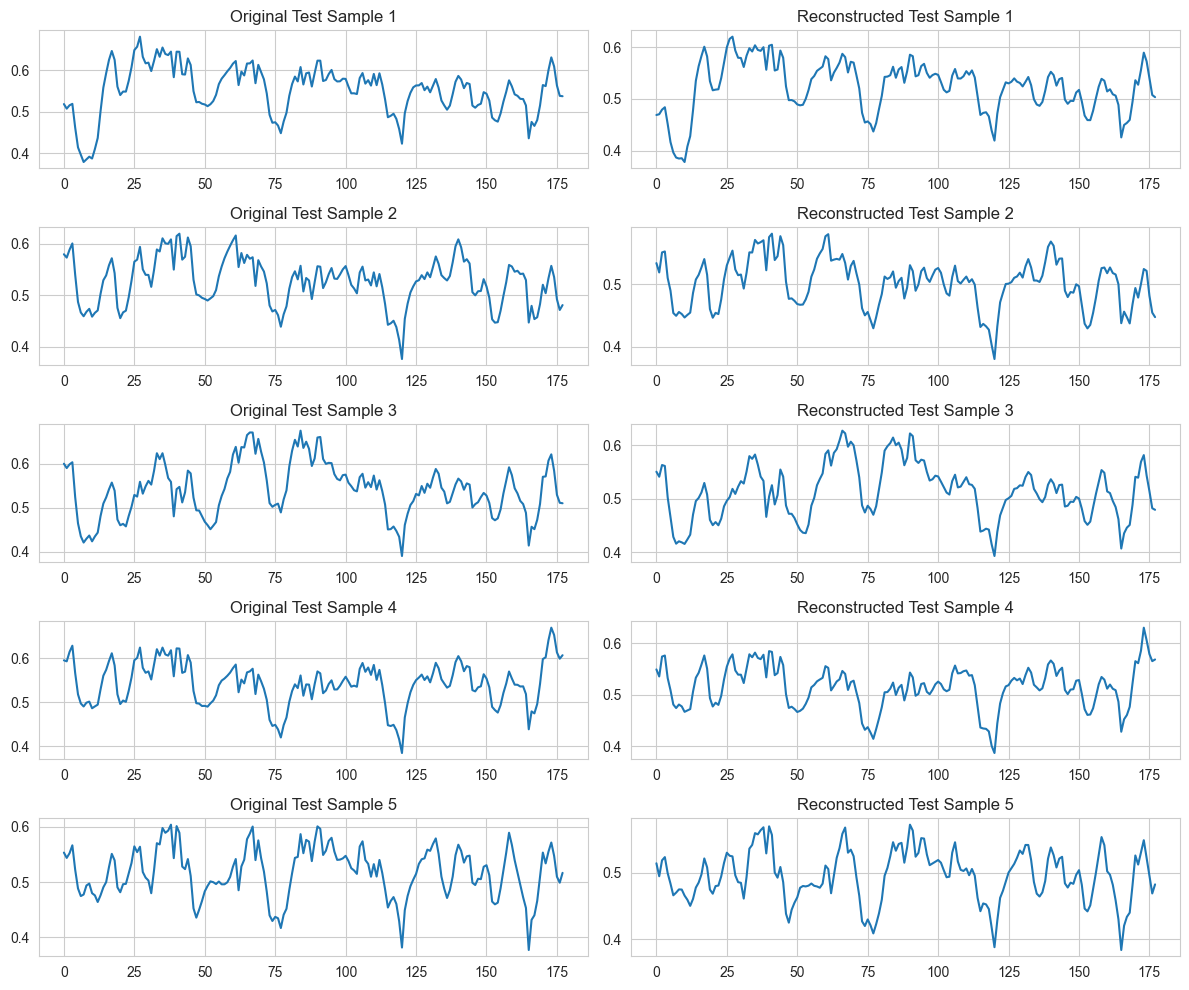

In [25]:
# # Plot the original and reconstructed test samples
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(X_test_scaled[0], label='Original')
# plt.title('Original Test Sample')
# plt.subplot(1, 2, 2)
# plt.plot(X_test_reconstructed[0], label='Reconstructed')
# plt.title('Reconstructed Test Sample')
# plt.show()

# Plot the first 5 test samples before and after reconstruction
num_samples_to_plot = 5

plt.figure(figsize=(12, 10))  # Adjust the figure size for multiple subplots
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 2, 2*i + 1)
    plt.plot(X_test_scaled[i], label='Original')
    plt.title(f'Original Test Sample {i+1}')
    
    plt.subplot(num_samples_to_plot, 2, 2*i + 2)
    plt.plot(X_test_reconstructed[i], label='Reconstructed')
    plt.title(f'Reconstructed Test Sample {i+1}')

plt.tight_layout()
plt.show()

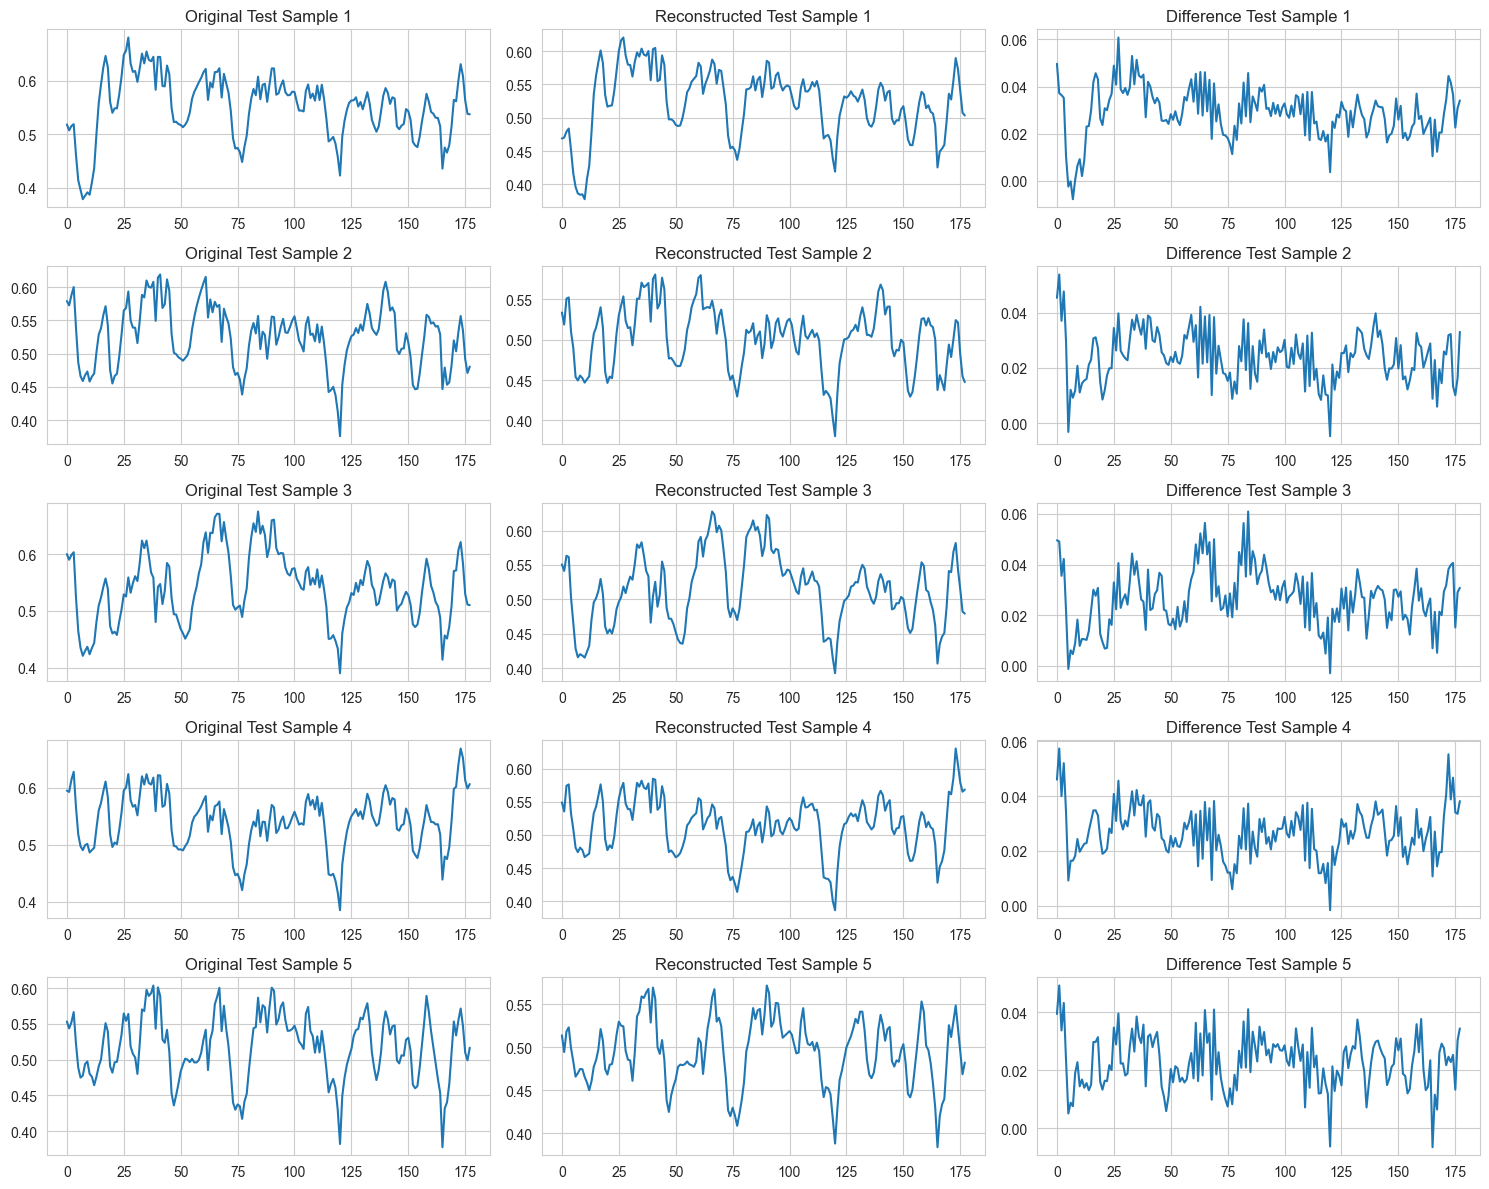

In [26]:
# Plot the original, reconstructed, and difference for the first 5 test samples
num_samples_to_plot = 5

plt.figure(figsize=(15, 12))  # Adjust the figure size for multiple subplots

for i in range(num_samples_to_plot):
    # Plot original sample
    plt.subplot(num_samples_to_plot, 3, 3*i + 1)
    plt.plot(X_test_scaled[i], label='Original')
    plt.title(f'Original Test Sample {i+1}')
    
    # Plot reconstructed sample
    plt.subplot(num_samples_to_plot, 3, 3*i + 2)
    plt.plot(X_test_reconstructed[i], label='Reconstructed')
    plt.title(f'Reconstructed Test Sample {i+1}')
    
    # Plot difference (original - reconstructed)
    plt.subplot(num_samples_to_plot, 3, 3*i + 3)
    plt.plot(X_test_scaled[i] - X_test_reconstructed[i], label='Difference')
    plt.title(f'Difference Test Sample {i+1}')

plt.tight_layout()
plt.show()
